In [1]:
import tensorflow as tf
from tensorflow import keras
import firebase_admin
from firebase_admin import ml
from firebase_admin import credentials
import tensorflow as tf


import numpy as np
import pandas as pd

cred = credentials.Certificate(
    r'..\AddressStandardisation\streetstandardisation-firebase-adminsdk-d65t2-de0cb0478f.json')

firebase_admin.initialize_app(cred,
                              options={'storageBucket': 'gs://streetstandardisation.appspot.com'})

data = pd.read_csv('./data.csv')

data.head()

# Extract street type from 'Street' column
data['Street Type'] = data['Street'].str.extract(r'(\b\w+$)', expand=True)

# get the features and labels
features = data['Non-Standardised Street']
labels = data['Street Type']

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# split the data into train and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create the encoder
vectorizer = CountVectorizer(binary=True)

# Fit the encoder and transform the training data
train_features = vectorizer.fit_transform(train_features)

# Transform the testing data
test_features = vectorizer.transform(test_features)



# Create the encoder
label_encoder = LabelEncoder()

# Fit the encoder and transform the labels
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Now you can one-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=43)
test_labels = to_categorical(test_labels, num_classes=43)

In [3]:
# Create the model
model = tf.keras.models.Sequential([
    keras.layers.Dense(
        16, input_dim=train_features.shape[1], activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(43, activation='softmax')  # Change this line
])

# Compile the model
model.compile(loss='categorical_crossentropy',  # Change this line
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model
model.fit(train_features, train_labels, epochs=10,
          validation_data=(test_features, test_labels))

# Evaluate the model
loss, accuracy = model.evaluate(test_features, test_labels)

print("Loss: ", loss)
print("Accuracy: ", accuracy)



d:\University\Capstone\Capstone_project_9785-24S1-18\proof_of_concept\.venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.6088 - loss: 1.6649 - val_accuracy: 0.9715 - val_loss: 0.1691
Epoch 2/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.9761 - loss: 0.1336 - val_accuracy: 0.9841 - val_loss: 0.0863
Epoch 3/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.9864 - loss: 0.0775 - val_accuracy: 0.9912 - val_loss: 0.0624
Epoch 4/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - accuracy: 0.9919 - loss: 0.0556 - val_accuracy: 0.9933 - val_loss: 0.0489
Epoch 5/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.9932 - loss: 0.0434 - val_accuracy: 0.9933 - val_loss: 0.0421
Epoch 6/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.9933 - loss: 0.0374 - val_accuracy: 0.9932 - val_loss: 0.0395
Epoch 7/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.9937 - loss: 0.0336 - val_accuracy: 0.9934 - val_loss: 0.0376
Epoch 8/10
12843/12843 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 

In [4]:
source = ml.TFLiteGCSModelSource.from_keras_model(model)

tflite_format = ml.TFLiteFormat(model_source=source)

model = ml.Model(
    display_name='street_standardisation_model',
    tags=['address', 'standardisation'],
    model_format=tflite_format
)

new_model = ml.create_model(model)
# The first time you publish a model, it will become the default version.
ml.publish_model(new_model.model_id)

AttributeError: 'Sequential' object has no attribute '_get_save_spec'

3211/3211 ━━━━━━━━━━━━━━━━━━━━ 3s 988us/step
[[6399    0    0 ...    0    0    0]
 [   0   47    0 ...    0    0    0]
 [   0    0  417 ...    0    0    0]
 ...
 [   0    0    0 ...  250    0    0]
 [   0    0    0 ...    0 2806    0]
 [   5    0    0 ...    0    1    9]]


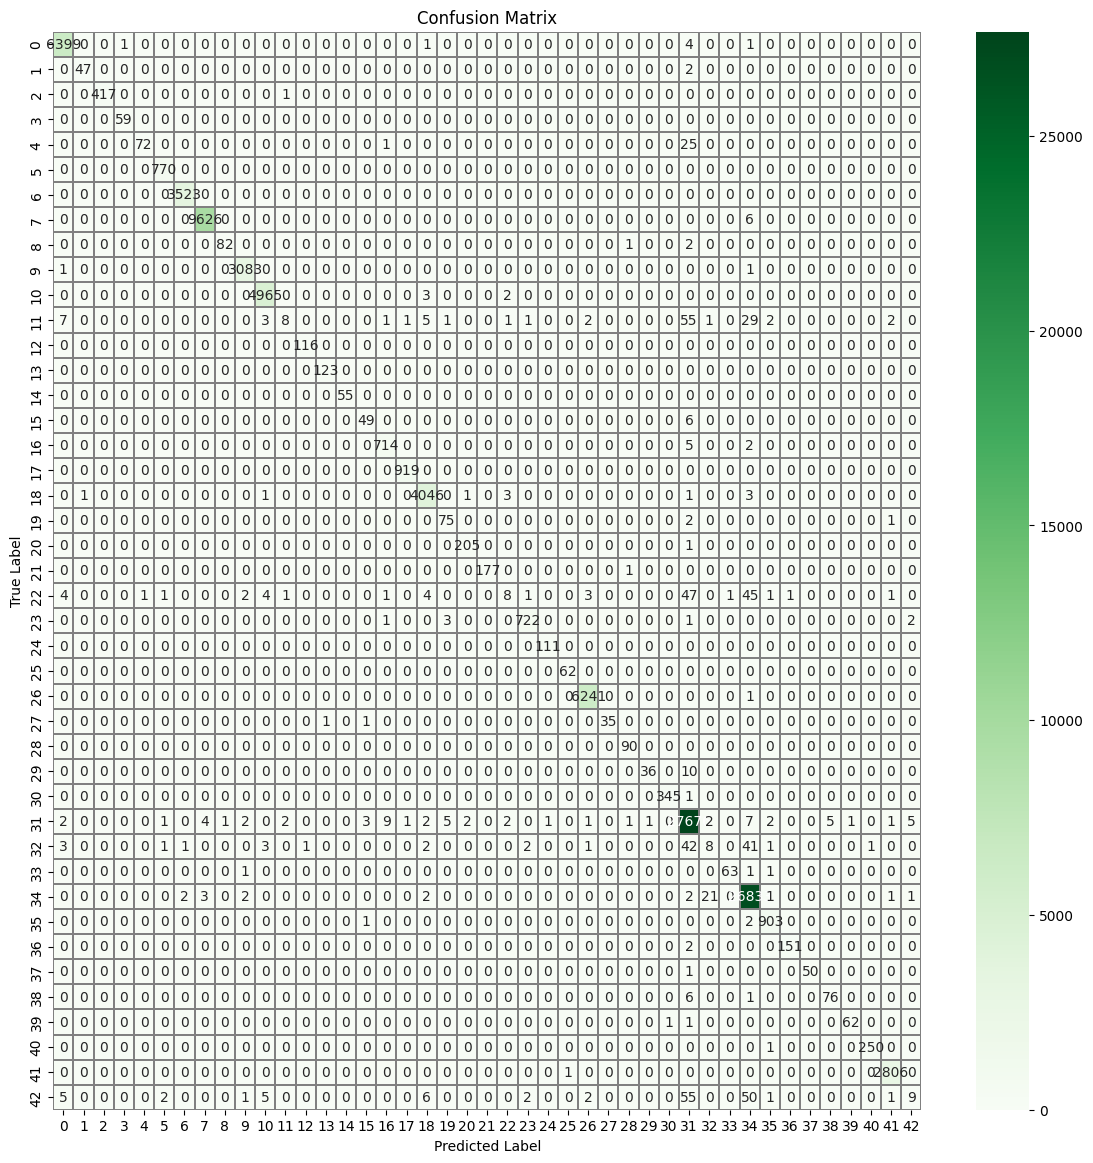

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict the values from the validation dataset
Y_pred = model.predict(test_features)

# Convert predictions classes from one hot vectors to labels: [0 0 1 0 0 ...] --> 2
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

# Convert validation observations from one hot vectors to labels
Y_true = np.argmax(test_labels, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

print(confusion_mtx)


# create cm using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# Increase the size of the figure
f, ax = plt.subplots(figsize=(14, 14))

# Plot the confusion matrix
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.0f', ax=ax)

# Set the labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_true, Y_pred_classes, target_names=label_encoder.classes_)

# get the classes and labels
for i, label in enumerate(label_encoder.classes_):
    print(f'{i}: {label}')




0: AVENUE
1: BEND
2: BOULEVARD
3: CHASE
4: CIRCLE
5: CIRCUIT
6: CLOSE
7: COURT
8: COVE
9: CRESCENT
10: DRIVE
11: EAST
12: ESPLANADE
13: GARDENS
14: GLADE
15: GREEN
16: GROVE
17: HIGHWAY
18: LANE
19: LINK
20: LOOP
21: MEWS
22: NORTH
23: PARADE
24: PARKWAY
25: PASS
26: PLACE
27: PROMENADE
28: RETREAT
29: RIDGE
30: RISE
31: ROAD
32: SOUTH
33: SQUARE
34: STREET
35: TERRACE
36: TRACK
37: TURN
38: VIEW
39: VISTA
40: WALK
41: WAY
42: WEST
